## Installing graph-tool (https://graph-tool.skewed.de)

To import a library that's not in Colaboratory by default, you can use !apt-get install.
But since graph-tool is not in the official repository, we need to add it to the list.

In [106]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.M9MUSL4Zt4/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: 8 signatures not checked due to missing keys
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://downloads.skewed.de/apt bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease

In [107]:
#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 72 not upgraded.
After this operation, 257 kB disk space will be freed.
(Reading database ... 159034 files and directories currently installed.)
Removing python3-cairo:amd64 (1.16.2-1) ...
W: Target Packages (main/binary-amd64/Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list:52
W: Target Packages (main/binary-all/Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list:52
W: Target Packages (main/binary-amd64/Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list:53
W: Target Packages (main/binary-all/Packages) i

Load the drive

In [108]:
from google.colab import drive
drive.mount('/content/drive')
# Mount the current directory
%cd /content/drive/My\ Drive//Work/Caltech/Spring 2022/CS 159 /Project/graph_homomorphism/GHC

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Work/Caltech/Spring 2022/CS 159 /Project/graph_homomorphism/GHC


# SVM Experiment

In [109]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113


In [110]:
# install ogb

!pip install ogb

In [111]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset, ZINC
import torch_geometric.utils as uts
from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [112]:
# Graph libraries

import networkx as nx 
from networkx.algorithms.isomorphism import ISMAGS, GraphMatcher

import graph_tool as gt
import graph_tool.topology as gt_topology

In [113]:
from ogb.graphproppred import PygGraphPropPredDataset

## Graph processing code

Encoders

In [117]:
def gt_Encoder_old(G, F_set ,symmetry = True, induced = False, format = 'Torch'):
    '''
    This function returns the subgraph isomorphism vector in R^|F_set| given by (subgraphIso(F,G)) 
    
    Inputs:
        G: Graph
        F_set (N, ): The set of test subgraphs, with each subgraph specifing full or line
        symmetry (optional, default = True) : counting embeddings F->G up to automorphisms of F or not. 
        induced (optional, default = False) : If True, only node-induced subgraphs are found.
        format (optional, default = Torch): desired output type
    Output:
        Enc(G): (N, ) vector of subgraph isomorphism counting
    '''
    # convert torch.geometric.data to gt_tools graph
    
    graph = torch_to_gt_tools(G)
    subIso = lambda x,y,n: gt_topology.subgraph_isomorphism(x,y,max_n = n, induced = induced)
    subIso_G = (subIso(F,graph,n) for F,n in F_set)
    numSubIso_G = map(lambda x: len(list(x)),subIso_G)

    # match format 
    if format == 'Torch':
        return torch.tensor(list(numSubIso_G))
    if format == 'numpy':
        return np.array((list(numSubIso_G))) 
 
def Simple_Encoder(G, F_set ,symmetry = True, line = True, format = 'Torch'):
    '''
    This function returns the subgraph isomorphism vector in R^|F_set| 
    given by (subgraphIso(F,G)) computed by graph_tools
    
    Inputs:
        G: Graph
        F_set (N, ): The set of test subgraphs, with each subgraph specifing full or line
        symmetry (default = True) : counting embeddings F->G up to automorphisms of F or not. 
        line (default = True) : whether to consider full subgraphs of line graph
        format (default = Torch): desired output type
    Output:
        Enc(G): (N, ) vector of subgraph isomorphism counting
    '''
    Isom = lambda x,y: ISMAGS(nx.line_graph(x),nx.line_graph(y)) if line else ISMAGS(x,y)
    Isom_G = (Isom(G,F) for F in F_set)
    numIso_G = map(lambda x: len(list(x.find_isomorphisms(symmetry))), Isom_G)

    # match format 
    if format == 'Torch':
        return torch.tensor(list(numIso_G))
    if format == 'numpy':
        return np.array((list(numIso_G)))
    pass

### Enriched embedding classses

In [161]:
####### converters ######################

def kx_to_gt(F):
  '''
  convert a networkX graph to gt_tools graph
  '''
  edge_list = F.edges
  graph = gt.Graph(directed=False)
  graph.add_edge_list(edge_list)
  gt.stats.remove_self_loops(graph)
  gt.stats.remove_parallel_edges(graph)

  return graph

def torch_to_nx(G):
    return uts.to_networkx(G, to_undirected = True)

def torch_to_gt_tools(G):
    '''
    convert torch.geometric.data to gt_tools graph
    '''
    return kx_to_gt(torch_to_nx(G))

In [278]:
#################################################

# Enriched encoders and test graph classes

#################################################

####### testgraph class ##########
class testGraph: 
  '''
  A class object for a test graph with descriptive features
  '''
  def __init__(self, graph, graph_name = None, max_n = 0, format = 'networkx'):
    '''
     Parameters:
     graph: a graph in the format "format" (default is networkX)
     graph_name (String): the name of a graph 
     max_n (Int): a bound for the number of subgraphs taken
    '''
    self.name = graph_name
    self.__graph = graph
    self.bound = max_n
    self.format = format
  def gt_graph(self):
    '''
     returns the graph in graph_tools format
    '''
    return kx_to_gt(self.__graph)
  def nx_graph(self):
    '''
     returns the graph in networkX format
    '''
    return self.__graph
  def pyg_graph(self):
    if self.format != 'networkx':
      raise Exception('Not implemented yet')
    return uts.convert.from_networkx(self.__graph)
  def draw(self):
    '''
     returns a drawing of the graph
    '''
    if self.format != 'networkx':
      return None
    return nx.draw(self.nx_graph())

###########################################################################


####### embedding class ##########

class gt_embedding:
  '''
  A class for for handeling the embeddings from subgraph isomorphism. 
  '''
  def __init__(self, graph, 
               testgraphs = None , 
               symmetry = True, 
               induced = False, 
               format = 'Torch'):
    self.__graph = graph
    if testgraphs == None: 
        self.testgraphs = {}
    else:
        self.testgraphs = testgraphs
    self.symmetry = symmetry
    self.induced = induced
    self.format = format
  def gt_graph(self):
    '''
     returns the encoded graph in graph_tools format
    '''
    if self.format == 'networkx':
      return kx_to_gt(self.__graph)
    # in the future we will have more formats, now just assume else is networkx
    return torch_to_gt_tools(self.__graph)
  def nx_graph(self):
    '''
     returns the encoded graph in networkX format
    '''
    if self.format == 'networkx':
        return self.__graph
    if self.format == 'Torch':
        return torch_to_nx(self.__graph)
    else:
      raise Exception('Not implemented yet')
  def pyg_graph(self):
    if self.format == 'Torch':
      return self.__graph
    else:
      raise Exception("Not implemented yet")
  def draw_graph(self):
    '''
     returns a drawing of the encoded graph
    '''
    return nx.draw(self.nx_graph())
  def add(self, test_graph):
    '''
     Adds a graph to the set of test graphs
     parameters:
     test_graph (testGraph) : graph to be added
    '''
    self.testgraphs[test_graph.name] = test_graph
  def add_from_iter(self, testgraphs):
    '''
     Adds graphs from an iterrable (e.g. list) to the set of test graphs
     parameters:
     testgraphs (testGraph) : iterator of graphs to be added
    '''
    dict_new_testgraphs = {F.name : F for F in testgraphs}
    self.testgraphs.update(dict_new_testgraphs)
  def __subIso(self, testgraph):
    # returns a list of subgraphs testgraphs -> graph
    return gt_topology.subgraph_isomorphism(testgraph.gt_graph(), 
                                            self.gt_graph(), 
                                            max_n = testgraph.bound, 
                                            induced = self.induced)
  def subIso(self, testgraph):
    # a public version of subIso, might be revoked in the future
      return self.__subIso(testgraph)
  def subIsodict(self):
    return {k: self.__subIso(v) for k, v in self.testgraphs.items()}
  def __pullback(self, testgraph, embedding,  format = 'Torch'):
    # returns the testgraph with features pulled back from the target graph along a map embedding
    '''
    input:
    testgraph (testGraph): a testgraph 
    embedding (gt_map) :  an embedding of testgraph into the graph
    returns:
    subgraph (torch-geometric.data): testgraph as pyg data with features pulled along embedding
    '''
    if self.format != 'Torch':
      raise Exception('Not implemented yet')
    g = self.gt_graph()
    vmask, emask = gt_topology.mark_subgraph(g, testgraph.gt_graph(), embedding)
    g.set_vertex_filter(vmask)
    node_indx = list(g.get_vertices())

    subgraph = testgraph.pyg_graph()

    embedding_x = self.__graph.x[node_indx]
    subgraph.x = embedding_x

    return subgraph

  def pullback(self, testgraph, embedding,  format = 'Torch'):
    # a public version of __pullback
    return self.__pullback(testgraph, embedding,  format = 'Torch')
  def num_encoder(self, format = 'Torch'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    subIsogen = (self.__subIso(test) for test in self.testgraphs.values())
    numSubIsolist = map(lambda x: len(list(x)),subIsogen)
    # match format 
    if format == 'Torch':
        return torch.tensor(list(numSubIsolist))
    if format == 'numpy':
        return np.array((list(numSubIsolist))) 



In [119]:
def gt_Encoder(G, F_set , symmetry = True, induced = False, format = 'Torch'):
  embedding = gt_embedding(G,  symmetry = symmetry, induced = induced, format = format)
  embedding.add_from_iter(F_set)

  return embedding.num_encoder(format = format)

## Modules for training

In [277]:
from networkx import exception
class Aggregation:
  '''
  A class to handle aggregation functions on graphs
  '''
  def __init__(self):
    pass

class GHC(Aggregation):
  def __init__(self, phi):
    self.func = phi
  def loc_agg(self, graph, format = 'Torch'):
    if format != 'Torch':
      raise Exception("Not implemented yet")
    vecfunc = np.vectorize(self.func, signature='(d)->()')
    x_nodes = graph.x.detach().numpy()

    return np.prod(vecfunc(x_nodes))








In [274]:
f = sum 
npf = np.vectorize(f, signature='(d)->()')

r = np.array([1,0,1])

npf(r)


array(2)

### Test graphs

In [122]:
MAX_n = 100
# cycles:
test_cycles = [testGraph(nx.cycle_graph(n), graph_name= f'c_{n}', max_n = MAX_n) for n in range(3,6)]
# trees:
make_tree = lambda tree, n, m : testGraph(tree, graph_name= f'tree of size {n} number {m}', max_n = MAX_n)
make_non_is_trees = lambda n : [make_tree(tree, n, m) for m, tree in enumerate(list(nx.nonisomorphic_trees(n)))]
test_trees = list(itertools.chain.from_iterable([make_non_is_trees(n) for n in range(2,6)]))
# cliques
test_cliques = [testGraph(nx.complete_graph(n), graph_name= f'_{n}', max_n = MAX_n) for n in range(4,6)]

F_testlist = list(itertools.chain(test_trees,test_cycles)) 
F_testlist_gt = list(map(lambda x : (x.gt_graph(), x.bound), F_testlist))



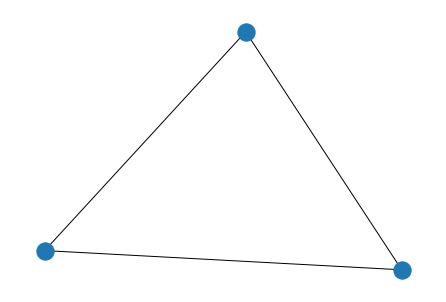

In [123]:
test_cycles[0].draw()

In [243]:
G = test_cycles[0]
F = test_trees[0]

G_nx = G.nx_graph()
G_tor = uts.from_networkx(G.nx_graph())
G_gt = G.gt_graph()

xs = torch.tensor([[1,0,0],[0,1,0],[0,0,1]])
G_tor.x = xs

G_tor.num_node_features


3

In [271]:
emb = gt_embedding(G_tor, format = 'Torch')

emb.add(F)
list_of_isos = emb.subIso(F)
pullbacks  = [emb.pullback(testgraph= F, embedding = e) for e in list_of_isos]

pullbacks[4].x


tensor([[1, 0, 0],
        [0, 0, 1]])

In [246]:
vm = list_of_isos
g = G.gt_graph()
sub = F.gt_graph()

vmask, emask = gt_topology.mark_subgraph(g, sub, vm[2])
g.set_vertex_filter(vmask)


indx = list(g.get_vertices())

F_tor = F.pyg_graph()

embedding_x = G_tor.x[indx]

F_tor.x = embedding_x


F_tor.x


tensor([[1, 0, 0],
        [0, 1, 0]])

## Start SVM experiment

set up environment 

In [265]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from yellowbrick.model_selection import CVScores
from sklearn.model_selection import StratifiedKFold

## First experiment: MUTAG:

Load the data

In [266]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/TUDataset/MUTAG/MUTAG.zip



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Processing...
Done!


Inspect:

In [267]:
embd = gt_embedding(dataset[0])
#embd.draw_graph()

len(list(embd.subIso(test_trees[0])))

38

In [268]:
gt_Encoder(dataset[0],F_testlist)

TypeError: ignored

Process the data

In [ ]:
# For MUTAG in networkX

# lables
#y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
#encode = lambda x: Simple_Encoder(to_kx(x),F_list, line = False, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])


In [ ]:
# For MUTAG in graph_tools with new library

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gt_Encoder(x, F_testlist, format ='numpy')
X = np.array([encode(data) for data in tqdm(dataset)])
#%timeit X = encode(dataset[0])
#encode(dataset[0])

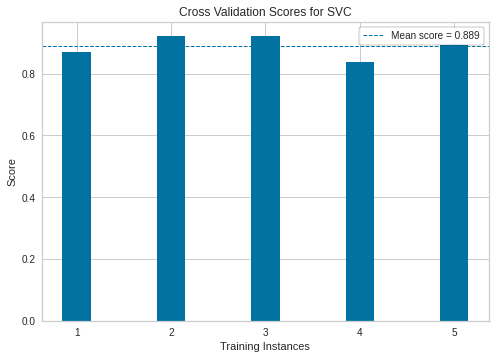

In [ ]:
# Run classifier - MUTAG

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   


## Experiment: IMDB 

In [ ]:
dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1], num_nodes=20)


Inspect:

In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[2])
#nx.draw(G)

dataset[2].y

tensor([0])

In [ ]:
# For IMDB-BIN in networkx

# lables
#y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
#encode = lambda x: Simple_Encoder(to_kx(x),F_list, line = False, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])
#encode(dataset[6])

In [ ]:
# For IMDB-BIN in graph_tools

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gtEncoder(x, F_testlist_gt, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
%timeit X = encode(dataset[0])
#encode(dataset[0])


10 loops, best of 5: 26.2 ms per loop


In [ ]:
# IMDB with new library

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gt_Encoder(x, F_testlist, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
%timeit X = encode(dataset[0])
#encode(dataset[0])

10 loops, best of 5: 29 ms per loop


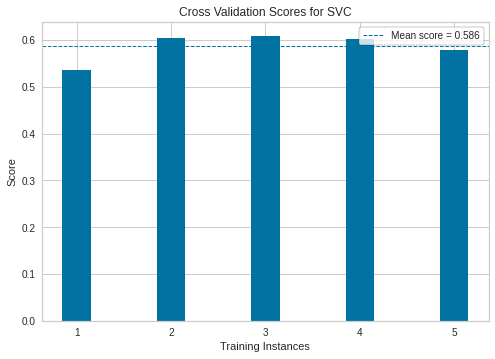

In [ ]:
# Run classifier - IMDB-BIN

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   

## Experiment: "ogbg-molhiv" 

In [ ]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 9
Number of classes: 2

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)


In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[0])
#nx.draw(G)
#dataset[1].edge_index
gt_Encoder(dataset[0], F_testlist)

tensor([ 40,  56,  72,  48, 100,  48,  24,   0,   0,   0,   0,   0,   0])

In [ ]:
# IMDB with new library

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gt_Encoder(x, F_testlist, format ='numpy')
X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])
#encode(dataset[0])

100%|██████████| 41127/41127 [07:06<00:00, 96.54it/s]


In [ ]:
y_fix = y[:,0]

IndexError: ignored

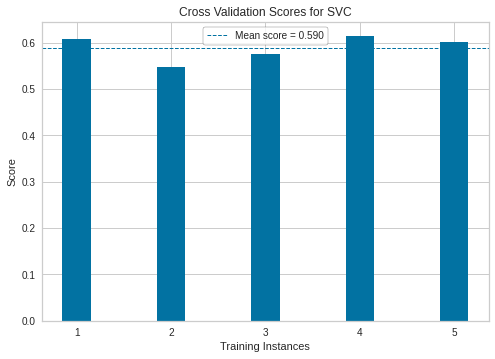

In [ ]:
# Run classifier - ogbg-molhiv

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='roc_auc', random_state=42)
visualizer.fit(X, y_fix)        
visualizer.show()   

## Zinc

In [ ]:
dataset = ZINC(root='data/ZINC',subset=True)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: ZINC(10000):
Number of graphs: 10000
Number of features: 1
Number of classes: 9994

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])


Inspect:

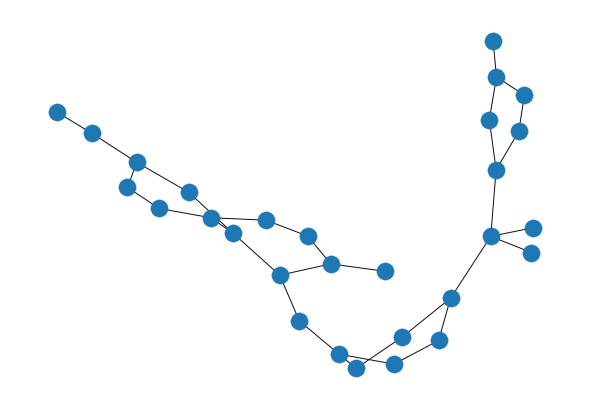

In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[0])
nx.draw(G)


Some statistics on the data set:

## ogbg-code2